## LeNet中加入BatchNormalization

In [1]:
!pip install d2l

     |████████████████████████████████| 83 kB 1.3 MB/s 


In [2]:
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
d2l.try_gpu()

device(type='cuda', index=0)

In [4]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
#     判断是训练模式还是预测模式
#     非训练模式则直接计算
    if not torch.is_grad_enabled():
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            mean = X.mean(dim=0, keepdim=True)
            var = ((X - mean) ** 2).mean(dim=0, keepdim=True)
        else:
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True) 
#         训练模式使用当前mean与var进行更新
        X_hat = (X - mean) / torch.sqrt(var + eps)
#     更新移动mean与移动var
        moving_mean = momentum*moving_mean + (1.0 - momentum)*mean
        moving_var = momentum*moving_var + (1.0 - momentum)*var
    Y = gamma*X_hat + beta
    return Y, moving_mean.data, moving_var.data

In [ ]:
X = torch.rand(size=(2,3))

In [ ]:
len(X.shape)

2

In [ ]:
mean = X.mean(dim=0, keepdim=True)

In [ ]:
mean

tensor([[0.2105, 0.0768, 0.2677]])

In [ ]:
((X - mean) ** 2).mean(dim=0, keepdim=True)

tensor([[0.0077, 0.0008, 0.0043]])

In [ ]:
X = torch.rand(size=(2,2,2,3))

In [ ]:
X.mean(dim=(0, 2, 3), keepdim=True).shape

torch.Size([1, 2, 1, 1])

In [5]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super(BatchNorm, self).__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.zeros(shape)
    
    def forward(self, X):
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        Y, self.moving_mean, self.moving_var = batch_norm(X, 
                                                          self.gamma, 
                                                          self.beta, 
                                                          self.moving_mean,
                                                          self.moving_var, 
                                                          1e-5, 
                                                          0.9)
        return Y

In [6]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.245, train acc 0.910, test acc 0.844
10367.1 examples/sec on cuda:0


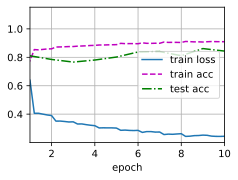

In [7]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())


In [8]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([1.6015, 1.8110, 1.3602, 2.4694, 2.5414, 1.4756], device='cuda:0',
        grad_fn=<ViewBackward>),
 tensor([-0.6609,  0.1127, -1.4290, -2.5406, -0.0729,  0.4007], device='cuda:0',
        grad_fn=<ViewBackward>))

In [9]:
net[1].gamma.shape

torch.Size([1, 6, 1, 1])

In [10]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.247, train acc 0.910, test acc 0.803
20270.7 examples/sec on cuda:0


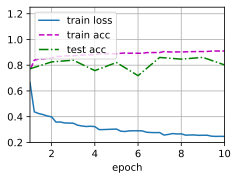

In [11]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())